## Decision Tree Machine Learning Model

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier

### Data Exploration and Preprocessing

In [2]:
df = pd.read_csv("n240.csv")

df = df.dropna(subset=['fire_occurrence'])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df.describe()

,region_id,temperature,humidity,wind_speed,rainfall,drough_index,previous_fire,fire_occurrence
count,13977.000000,14018.000000,14002.000000,14001.000000,14005.000000,14006.000000,14013.000000,14293.000000
mean,25.504543,24.949192,50.026495,19.969888,6.018308,0.532367,0.397702,0.400826
std,14.426858,8.954107,22.230315,11.961369,10.015685,0.120682,0.489441,0.490083
min,1.000000,-2.934487,-0.979070,-7.498165,0.000000,0.003009,0.000000,0.000000
25%,13.000000,18.157908,30.130641,9.944791,0.000000,0.486219,0.000000,0.000000
50%,25.000000,25.001042,49.863411,19.886857,1.628201,0.559070,0.000000,0.000000
75%,38.000000,31.756289,69.925063,30.005607,7.793909,0.609216,1.000000,1.000000
max,50.000000,53.672885,101.474501,48.199633,114.091525,0.769467,1.000000,1.000000


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14293 entries, 7956 to 16061
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region_id        13977 non-null  float64
 1   date             14023 non-null  object 
 2   temperature      14018 non-null  float64
 3   humidity         14002 non-null  float64
 4   wind_speed       14001 non-null  float64
 5   rainfall         14005 non-null  float64
 6   vegetation_type  14021 non-null  object 
 7   drough_index     14006 non-null  float64
 8   previous_fire    14013 non-null  float64
 9   fire_occurrence  14293 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.2+ MB


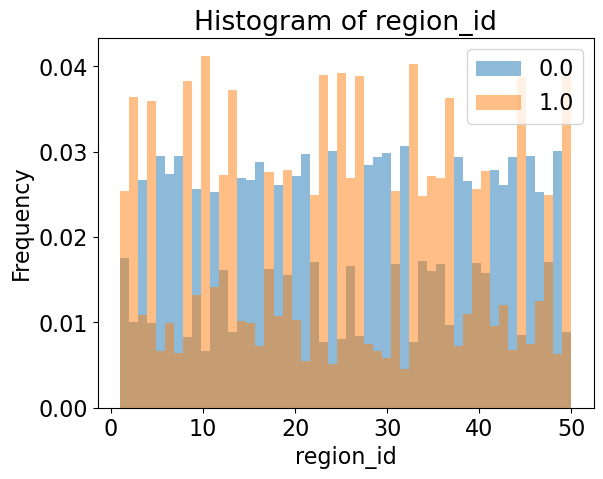

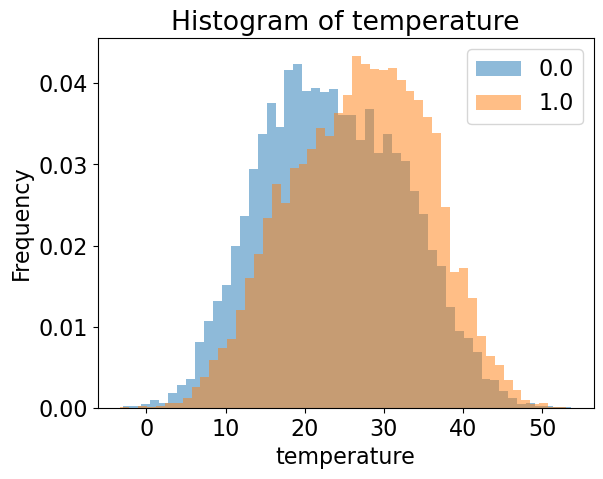

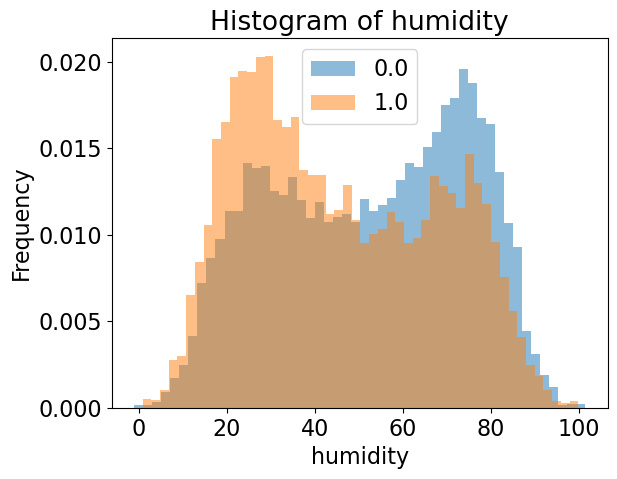

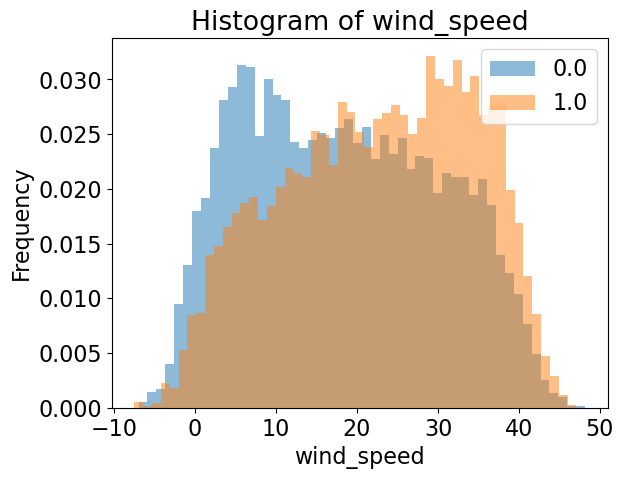

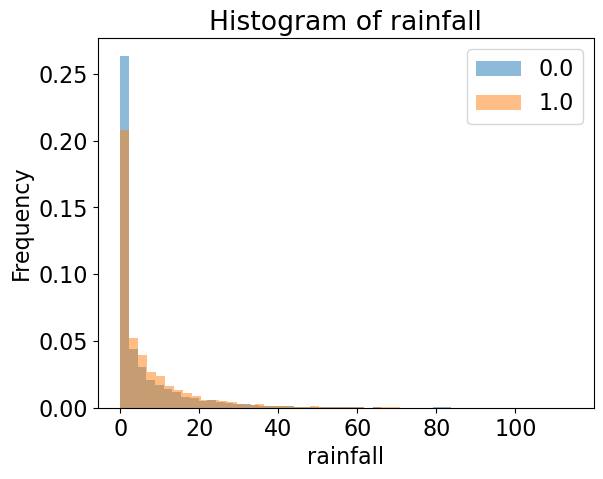

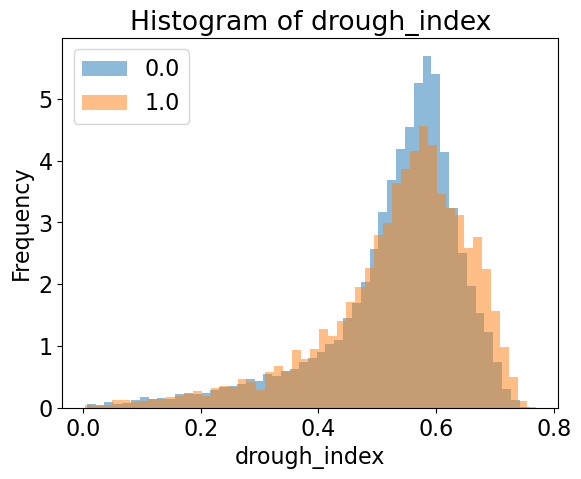

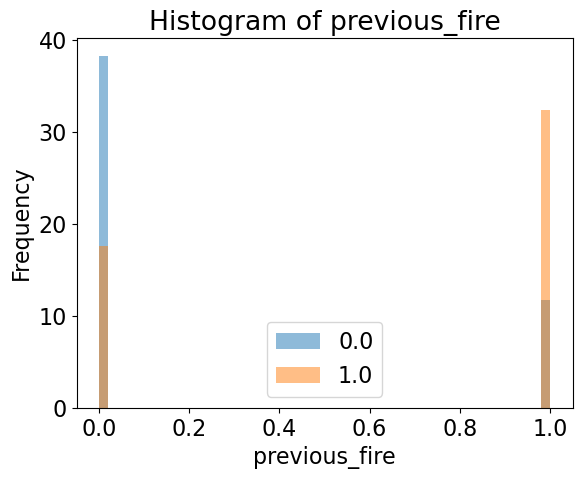

In [4]:
features = ['region_id', 'temperature', 'humidity', 'wind_speed','rainfall', 'drough_index', 'previous_fire']

for feat in features:
    df.groupby("fire_occurrence")[feat].plot.hist(bins=50, alpha=0.5, legend=True, density = True, title = "Histogram of " + feat);
    plt.xlabel(feat)
    plt.show()

In [116]:
numerical_feature = ['temperature', 'humidity', 'wind_speed','rainfall', 'drough_index']
categorical_feature = ['vegetation_type']
drop_features = ['region_id', 'date', 'previous_fire']
target = 'fire_occurrence'

In [117]:
num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

preprocessor = make_column_transformer(
    (num_pipe, numerical_feature),
    (cat_pipe, categorical_feature),
    ("drop", drop_features)
)

preprocessor.fit(X_train, y_train)
ohe_feature = list(preprocessor.named_transformers_['pipeline-2'].named_steps["onehotencoder"].get_feature_names_out(categorical_feature))
total_feat = numerical_feature + ohe_feature
total_feat

['temperature',
 'humidity',
 'wind_speed',
 'rainfall',
 'drough_index',
 'vegetation_type_Coniferous Forest',
 'vegetation_type_Deciduous Forest',
 'vegetation_type_Grassland',
 'vegetation_type_Mixed Forest',
 'vegetation_type_Shrubland',
 'vegetation_type_missing']

### Model Development

In [118]:
X_train = train_df.drop(columns=target)
y_train = train_df['fire_occurrence']
X_test = test_df.drop(columns=target)
y_test = test_df['fire_occurrence']

#### Linear Regression

In [119]:
pipe_lr = make_pipeline(
    preprocessor,
    LogisticRegression(random_state=123)
)

In [120]:
param_grid = {
    "logisticregression__C": [0.001, 0.01, 0.1, 1.0, 10, 100]
}
gs = GridSearchCV(pipe_lr, 
                  param_grid = param_grid, 
                  n_jobs=-1, 
                  return_train_score=True
                 )
gs.fit(X_train, y_train)
gs.best_params_

{'logisticregression__C': 0.01}

In [121]:
pipe_lr_best = make_pipeline(
    preprocessor,
    LogisticRegression(C=gs.best_params_["logisticregression__C"],random_state=123)
)
pipe_lr_best.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### Decision Tree

In [122]:
pipe_dt = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(random_state=123)
)
pipe_dt.fit(X_train, y_train)

max_depth = pipe_dt.named_steps['decisiontreeclassifier'].get_depth()
max_depth

39

In [123]:
depths = np.arange(1, max_depth, 2)
mean_train_accuracy = []
mean_validation_accuracy = []

for i in depths:
    pipe = make_pipeline(
        preprocessor,
        DecisionTreeClassifier(max_depth=i, random_state=123)
    )
    result = cross_validate(pipe, X_train, y_train, cv=10, return_train_score=True)
    mean_train_accuracy.append(result['train_score'].mean())
    mean_validation_accuracy.append(result['test_score'].mean())
    

results_df = pd.DataFrame({"train_score": mean_train_accuracy, 
                           "valid_score": mean_validation_accuracy
                           },
                           index=depths)
results_df

,train_score,valid_score
1,0.718673,0.718674
3,0.756656,0.751907
5,0.777677,0.770797
7,0.792548,0.766389
9,0.818979,0.750648
11,0.855438,0.737075
13,0.894167,0.723362
15,0.928924,0.709789
17,0.955394,0.703422
19,0.974121,0.694467


<Axes: title={'center': 'Pediction Tree Depths vs. Accuracy'}, xlabel='depths', ylabel='accuracy'>

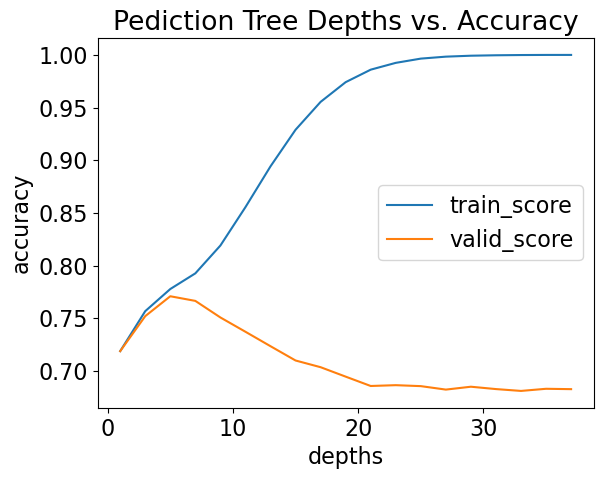

In [124]:
results_df.plot(ylabel="accuracy",xlabel="depths", title="Pediction Tree Depths vs. Accuracy")

In [125]:
best_max_depth = results_df['valid_score'].idxmax()
best_pipe_dt = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth=best_max_depth, random_state=123)
)
best_pipe_dt.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### Random Forest

In [126]:
pipe_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(max_depth=36, random_state=123)
)
result = cross_validate(pipe_rf, X_train, y_train, cv=5, return_train_score=True)
pd.DataFrame(result)

,fit_time,score_time,test_score,train_score
0,1.366190,0.037561,0.754110,0.999825
1,1.349603,0.033811,0.760056,1.000000
2,1.253481,0.034097,0.752361,0.999913
3,1.265618,0.039545,0.770469,1.000000
4,1.269613,0.034070,0.769769,1.000000


In [127]:
pipe_rf.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Model Evaluation

#### Linear Regression

In [128]:
test_score = pipe_lr_best.score(X_test, y_test)
test_score

0.7786793508673755

In [130]:
data = {
    "coefficient": pipe_lr_best.named_steps["logisticregression"].coef_[0].tolist(),
    "magnitude": np.absolute(pipe_lr_best.named_steps["logisticregression"].coef_[0].tolist()),
}
coef_df = pd.DataFrame(data, index=total_feat).sort_values(
    "magnitude", ascending=False
)
coef_df

,coefficient,magnitude
vegetation_type_Grassland,1.606774,1.606774
vegetation_type_Deciduous Forest,-1.200730,1.200730
vegetation_type_Mixed Forest,-0.704323,0.704323
vegetation_type_Shrubland,0.652655,0.652655
temperature,0.511861,0.511861
wind_speed,0.465225,0.465225
vegetation_type_Coniferous Forest,-0.396420,0.396420
humidity,-0.390690,0.390690
drough_index,0.137248,0.137248
rainfall,0.041555,0.041555


#### Decision Tree

In [131]:
test_score = best_pipe_dt.score(X_test, y_test)
test_score

0.7756015668718522

In [139]:
importance = pd.DataFrame( 
    data = {
        "features": total_feat,
        "feature_importances": best_pipe_dt.named_steps['decisiontreeclassifier'].feature_importances_
    }
)
importance.sort_values("feature_importances", ascending=False)

,features,feature_importances
7,vegetation_type_Grassland,0.466991
9,vegetation_type_Shrubland,0.231707
0,temperature,0.104647
2,wind_speed,0.104306
1,humidity,0.075879
6,vegetation_type_Deciduous Forest,0.016470
3,rainfall,0.000000
4,drough_index,0.000000
5,vegetation_type_Coniferous Forest,0.000000
8,vegetation_type_Mixed Forest,0.000000


#### Random Forest

In [140]:
test_score = pipe_rf.score(X_test, y_test)
test_score

0.7646894236149973

In [141]:
data = {
    "importance": pipe_rf.named_steps['randomforestclassifier'].feature_importances_.tolist(),
}
coef_df = pd.DataFrame(data, index=total_feat).sort_values(
    "importance", ascending=False
)
coef_df

,importance
wind_speed,0.173444
temperature,0.167905
humidity,0.165234
drough_index,0.139996
vegetation_type_Grassland,0.115762
rainfall,0.100001
vegetation_type_Deciduous Forest,0.059750
vegetation_type_Shrubland,0.038183
vegetation_type_Mixed Forest,0.025364
vegetation_type_Coniferous Forest,0.011599
